# Longevity Risk Modeling


- reading: Chapters 7 to 9, Milevsky's "Retirement Income Recipes in R"
- data: Human Mortality Database (https://www.mortality.org/)

1. Define $(T_x, L_\xi)$
    - $T_x$: remaining lifetime of a person whoes current age is $x$
    - $L_\xi$: longevity of an investment portfolio, where $\xi$ is the initial withdrawal rate 


In [1]:
setwd("C:/Users/edgar/Dropbox/00_Teaching/HYU_FAC9073_Pension_Economics/Lecture_notes")
getwd()

[1] "C:/Users/edgar/Dropbox/00_Teaching/HYU_FAC9073_Pension_Economics/Lecture_notes"

In [2]:
CLT_1925 <- read.csv("./data/Canada_Cohort_Lifetable_1925.csv")
CLT_1940 <- read.csv("./data/Canada_Cohort_Lifetable_1940.csv")
summary(CLT_1925)
summary(CLT_1940)

      AGE            FEMALE            MALE             YEAR     
 Min.   : 0.00   Min.   : 42021   Min.   : 24183   Min.   :1925  
 1st Qu.:21.25   1st Qu.: 75343   1st Qu.: 64119   1st Qu.:1946  
 Median :42.50   Median : 83754   Median : 78750   Median :1968  
 Mean   :42.50   Mean   : 78760   Mean   : 70991   Mean   :1968  
 3rd Qu.:63.75   3rd Qu.: 85971   3rd Qu.: 82245   3rd Qu.:1989  
 Max.   :85.00   Max.   :100000   Max.   :100000   Max.   :2010  

      AGE           FEMALE            MALE             YEAR     
 Min.   : 0.0   Min.   : 78397   Min.   : 68187   Min.   :1940  
 1st Qu.:17.5   1st Qu.: 88222   1st Qu.: 82888   1st Qu.:1958  
 Median :35.0   Median : 91034   Median : 87406   Median :1975  
 Mean   :35.0   Mean   : 89671   Mean   : 85459   Mean   :1975  
 3rd Qu.:52.5   3rd Qu.: 92144   3rd Qu.: 89843   3rd Qu.:1992  
 Max.   :70.0   Max.   :100000   Max.   :100000   Max.   :2010  

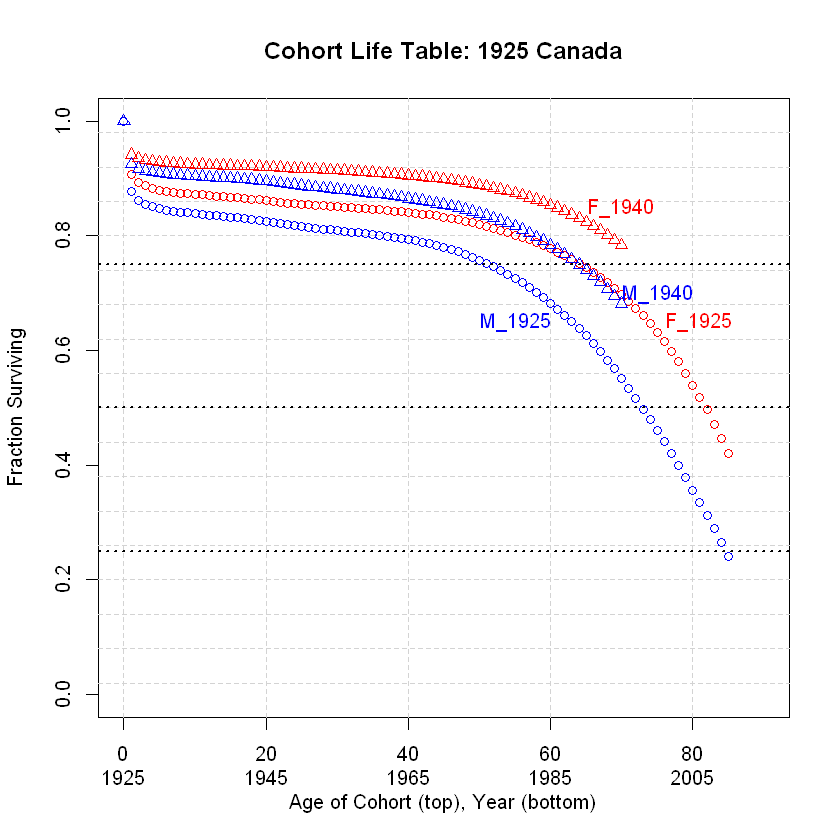

In [3]:
plot(c(0,90),c(0,1),type="n", xlab="Age of Cohort (top), Year (bottom)",
    ylab="Fraction Surviving")
title("Cohort Life Table: 1925 Canada")
grid(ny=18, lty=20)
for (i in 1:86){
    points(i-1,CLT_1925$FEMALE[i]/100000, col="red")
    points(i-1,CLT_1925$MALE[i]/100000, col="blue") 
}
for (i in 1:71){
    points(i-1,CLT_1940$FEMALE[i]/100000, col="red", pch=2)
    points(i-1,CLT_1940$MALE[i]/100000, col="blue", pch=2) 
}
abline(h=0.25, col="black", lty=3, lwd=2)
abline(h=0.50, col="black", lty=3, lwd=2)
abline(h=0.75, col="black", lty=3, lwd=2)
year <- 1925 + c(0:5)*20; age <- 0 + c(0:5)*20
axis(side=1, line=1, at=age, labels=year, tick=F)
text(81, 0.65, "F_1925", col="red")
text(70, 0.85, "F_1940", col="red")
text(55, 0.65, "M_1925", col="blue")
text(75, 0.7, "M_1940", col="blue")

$$ q_x = \frac{S_x - S_{x+1}}{S_x} $$  

In [4]:
# diff(.) creates a vector of differences of adjacent values.
qx_f <- (-diff(CLT_1925$FEMALE))/CLT_1925$FEMALE[-length(CLT_1925$FEMALE)]
# CLT_1925$FEMALE[-length(CLT_1925$FEMALE)] == CLT_1925$FEMALE[1:85]
qx_m <- (-diff(CLT_1925$MALE))/CLT_1925$MALE[-length(CLT_1925$MALE)]
# minimum mortality rate
qx_f[which(qx_f == min(qx_f))]
qx_m[which(qx_m == min(qx_m))]

[1] 0.0007434629

[1] 0.001394211

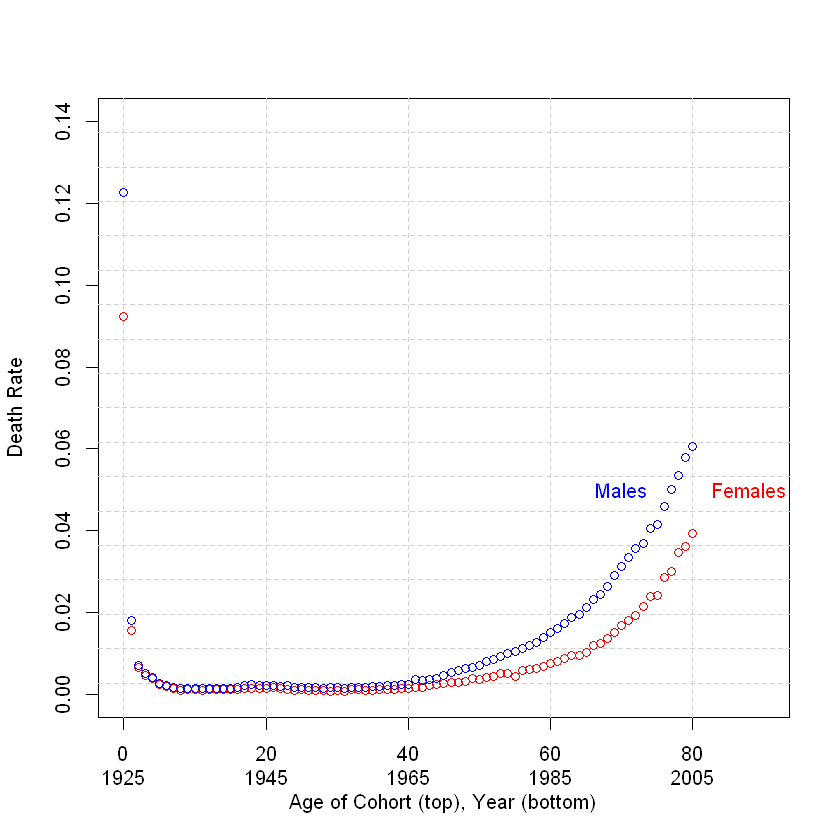

In [5]:
plot(c(0,90),c(0,0.14),type="n", xlab="Age of Cohort (top), Year (bottom)",
     ylab="Death Rate")
grid(ny=18,lty=20)
for (i in 1:81){
    points(i-1,qx_f[i],col="red")
    points(i-1,qx_m[i],col="blue") }
year <- 1925 + c(0:5)*20; age <- 0 + (0:5)*20
axis(side=1,line=1,at=age,labels=year,tick=F)
text(88,0.05,"Females",col="red")
text(70,0.05,"Males",col="blue")

$$ S_x = S_0 \prod_{i=1}^{x-1} (1-q_i) $$

In [6]:
LifeTable <- 100000*cumprod(1-qx_f)
LifeTable <- c(100000,LifeTable)
all.equal(LifeTable,CLT_1925$FEMALE)

[1] TRUE

$$ {_{y-x}q_x} = {_{n}q_x} := 1 - \frac{S_{x+n}}{S_x} = 1 - \prod_{i=x}^{x+n-1} (1-q_i) = 1 - {{_n}p_x}$$

In [17]:
# n-year survival rates for a given vector of 1-year death rates qx
SPQR <- function(x,y,qx){
    LT <- cumprod(1-qx)
    LT <- c(1,LT)
    LT[y+1]/LT[x+1]
}

SPQR(50,80,qx_f)

[1] 0.6586827

Let me \textit{casually postulate} that $q_x$ values grow exponentially between the age of (approximately) 35 and 85.
$$ q_{x+n} = q_x e^{g n}, $$
where $q_x$ is the death rate at some baseline age $x$, the index $n$ is measured in years, and g is the growth rate of death rates.
$$ \ln(q_{x+n}) = \ln(q_x) + g n $$

In [13]:
var_yf=log(qx_f[36:85]/qx_f[35]); var_xf = c(1:50);
model_f = lm(var_yf ~ var_xf) #ols
var_ym=log(qx_m[36:85]/qx_m[35]); var_xm = c(1:50);
model_m = lm(var_ym ~ var_xm) #ols
summary(model_f)
summary(model_m)


Call:
lm(formula = var_yf ~ var_xf)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.168012 -0.054109  0.000791  0.042611  0.172290 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0148409  0.0213388   0.695     0.49    
var_xf      0.0783162  0.0007283 107.535   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.07432 on 48 degrees of freedom
Multiple R-squared:  0.9959,	Adjusted R-squared:  0.9958 
F-statistic: 1.156e+04 on 1 and 48 DF,  p-value: < 2.2e-16



Call:
lm(formula = var_ym ~ var_xm)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.192628 -0.051621  0.009157  0.054000  0.120224 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.079224   0.021887    3.62 0.000709 ***
var_xm      0.076426   0.000747  102.31  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.07622 on 48 degrees of freedom
Multiple R-squared:  0.9954,	Adjusted R-squared:  0.9953 
F-statistic: 1.047e+04 on 1 and 48 DF,  p-value: < 2.2e-16


In [14]:
qx_m.new <- qx_m[85]*exp(c(1:15)*0.076)
qx_m_new <- append(qx_m, qx_m.new, after=85)
LT_m <- 100000*cumprod(1-qx_m_new)
LT_m <- append(LT_m,100000,after=0)
LT_m[101]

qx_f.new <- qx_f[85]*exp(c(1:15)*0.076)
qx_f_new <- append(qx_f, qx_f.new, after=85)
LT_f <- 100000*cumprod(1-qx_f_new)
LT_f <- append(LT_f,100000,after=0)
LT_f[101]

[1] 1372.044

[1] 6660.633

* $\theta(t)$: the __survival probability__ to any given time t. $\theta(0)=1$
$$ \lambda_t = -\frac{\theta\prime(t)}{\theta(t)} \qquad \Longleftrightarrow \qquad \theta(t) = e^{-\int_o^t \lambda_s \mathrm{d}s}$$
* If $\lambda_x$ is a constant, let say $\lambda$, the suvival probability does not fit to the empirical data, i.e., human survivial probability. Instead, we may assume that
$$ \ln(\lambda_x) = \ln(h_0) + g x,$$
where $\ln(h_0) = - \ln(b) - m/b$ and $g = 1/b $.
    - $m$: the model value of life, the age at which this person is most likely to die, but NOT the mean lifetime $\mathbb{E}[T_x]$. 
    - $b$: dispersion coefficient, NOT the standard deviation of the lifetime
* The Gompertz survival probability follows
$$ \theta(t) = Pr\left[T_x \ge t\right] = \exp \left[ e^{(x-m)/b} (1-e^{t/b}) \right] = {_t}p_x,$$
ignoring the Makeham term.
    - There are no exact expressions for the mean of the Gompertz random variable, but we can calculate it numerically.
    - The Gompertz model does not work well for describing mortality at younger ages, e.g., $x<30$.

In [15]:
# Gompertz survival probability 
TPXG <- function(x,t,m,b){exp(exp((x-m)/b)*(1-exp(t/b)))}
round(TPXG(85,15,85,10), digits=3)
# the result above is the same as the below
m<-85; b<-10; x<-85
lambda <- function(t){-(1/b)*exp((x+t-m)/b)}
round(exp(integrate(lambda,0,15)$value),digits=3)

[1] 0.031

[1] 0.031

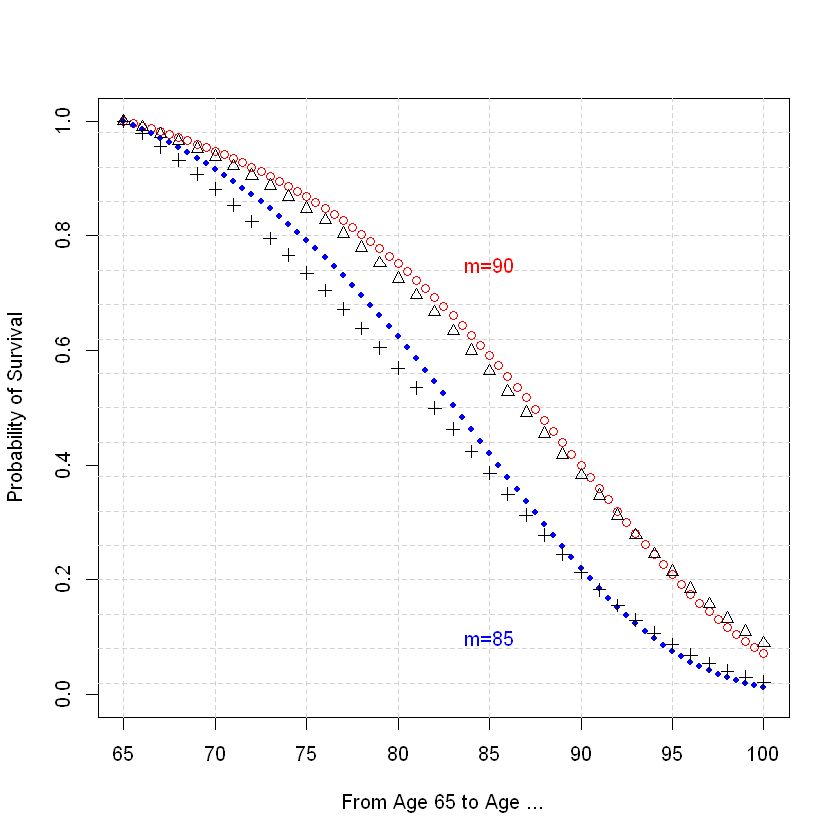

In [18]:
plot(c(65,100),c(0,1), type="n", xlab="From Age 65 to Age ...",
    ylab="Probability of Survival")
grid(ny=18,lty=20)
for (i in 0:70){
    points(65+i/2,TPXG(65,i/2,90,10),col="red")
    points(65+i/2,TPXG(65,i/2,85,10),col="blue",pch=20) 
    }
for (i in 0:35){
    points(65+i,SPQR(65,65+i,qx_f_new), col="black",pch=2)
    points(65+i,SPQR(65,65+i,qx_m_new), col="black",pch=3)
}
text(85,0.75,"m=90",col="red")
text(85,0.10,"m=85",col="blue")

$$ \mathbb{E} \left[ T_x \right] = \int_{0}^{\infty} Pr \left[ T_x \ge t \right] \mathrm{d}t $$

In [12]:
m <- 88; b<-10; x<-65
theta <- function(t){TPXG(x,t,m,b)}
round(integrate(theta,0,45)$value, digits=2)

[1] 20.13

$$ t = b \ln \left[ 1 - \ln({_t}p_x) e^{(m-x)/b}  \right] $$

In [13]:
GRAN <- function(N,x,m,b){b*log(1-log(runif(N))*exp((m-x)/b))}
round(65+GRAN(20,65,90,10),1)

[1]  83.1  88.2  89.0  90.2  84.1  67.3  78.2  77.5  91.4 100.2 100.4  95.7
[13]  99.3  84.4  82.8 105.6  90.5  67.7  96.5  86.5

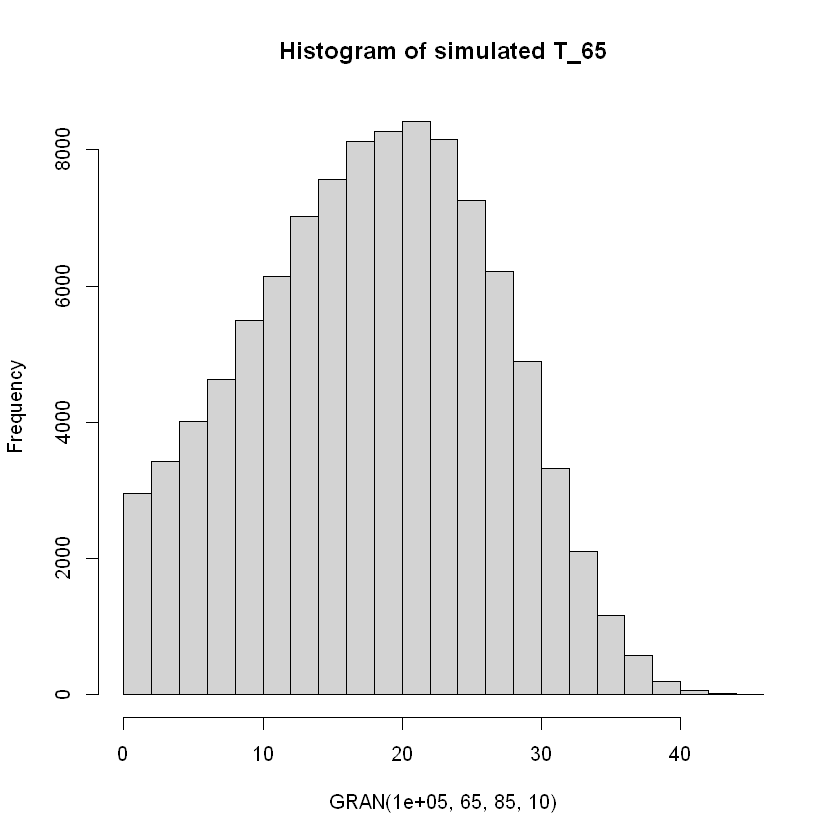

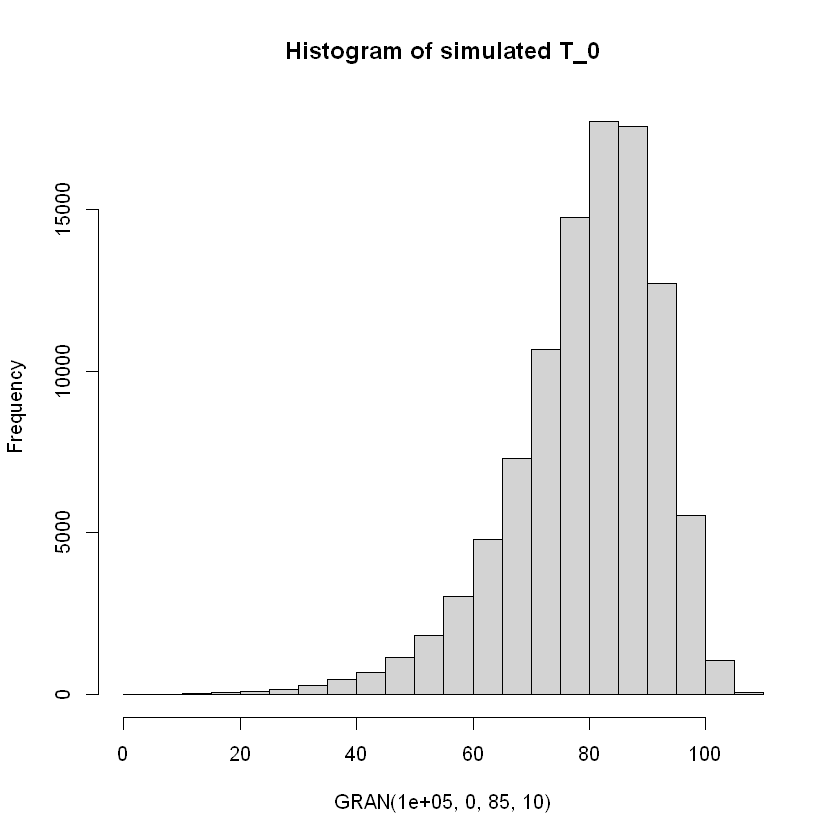

In [14]:
# T_x, where x = 65
hist(GRAN(100000,65,85,10),main="Histogram of simulated T_65") 
# T_0, equiv to the age at death
hist(GRAN(100000,0,85,10), main="Histogram of simulated T_0") 

In [100]:
zdat <- GRAN(1000000,0,85,10) # given x=0
round(summary(zdat),digits=2)
paste("sample mean: ", round(mean(zdat),digits=2), "; sample std: ", round(sd(zdat),digits=2))
# the mean and standard deviation of Gompertz distribution can be approximated by
paste("appx mean: ", round(85+10*digamma(1),digits=2), "; appx std: ", round(pi*10/sqrt(6),digits=2))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.02   72.52   81.33   79.23   88.27  111.23 

[1] "sample mean:  79.23 ; sample std:  12.78"

[1] "appx mean:  79.23 ; appx std:  12.83"

In [101]:
sd(GRAN(100000,55,85,10))
sd(GRAN(100000,60,85,10))
sd(GRAN(100000,65,85,10))
sd(GRAN(100000,70,85,10))

[1] 10.21098

[1] 9.475297

[1] 8.568905

[1] 7.535302

- The dispersion coefficient $b$ is lower than the true standard deviaion of life, __early in life__.
- Then, at advanced ages $x$, the $SD[T_x] < b$.

In [114]:
zdat <- 65 + GRAN(1000000,65,90,10)
zdat[zdat<100] <- 0; zdat[zdat>=100] <- 1
# simulation frequency
round(sum(zdat)/length(zdat),digits=4)
# analytic probability
round(TPXG(65,35,90,10),digits=4)

[1] 0.0719

[1] 0.0716

In [119]:
# from simulated zdat to the CLT and q_x table
LTLD <- function(z){
    z<-sort(z); N<-length(z); LT<-c();
    LT[1]<-N; T<-ceiling(max(z))+1
    for(i in 2:T){
        LT[i] <- N - length(z[z <= i-1])
    }
    LT
}

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.04582  77.53761  86.34693  84.24512  93.27368 118.00173 

[1] 1000000  999981  999969  999948  999919  999900  999870  999848  999822
 [10]  999790  999762  999720  999686  999638  999588  999539  999477  999401
 [19]  999329  999243  999177  999075  998954  998835  998707  998552  998392
 [28]  998239  998066  997842  997616  997316  997036  996702  996373  995981
 [37]  995549  995076  994545  993986  993345  992615  991836  990995  990081
 [46]  989049  987935  986668  985257  983788  982020  980161  978139  975805
 [55]  973211  970420  967379  963893  960170  955979  951530  946526  941114
 [64]  935032  928608  921331  913353  904515  895036  884548  873415  860960
 [73]  847497  833101  817347  800138  781628  761542  739893  717170  692596
 [82]  666279  638454  609027  578215  545656  512036  477003  441679  405368
 [91]  368811  331980  295370  259513  225292  192636  161930  133661  108028
[100]   85723   66146   49781   36269   25599   17492   11406    7063    4159
[109]    2344    1192     624     287     115      37      11       6       2
[118]       1       1       0

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.1455  77.5647  86.3349  84.2411  93.2627 116.1358 

[1] 1000000  999991  999977  999958  999942  999919  999897  999876  999844
 [10]  999815  999778  999746  999711  999670  999628  999579  999507  999451
 [19]  999380  999306  999205  999092  998978  998861  998716  998572  998421
 [28]  998250  998063  997852  997613  997353  997079  996762  996438  996056
 [37]  995617  995135  994575  994018  993347  992651  991827  991001  989954
 [46]  988892  987724  986404  984991  983422  981766  979914  977863  975594
 [55]  973124  970376  967283  963839  960062  956038  951584  946582  941150
 [64]  935177  928665  921415  913453  904642  895127  884842  873560  861291
 [73]  847753  833087  817364  800361  781789  761958  740479  717436  692690
 [82]  666339  638376  608666  577393  545234  511538  476808  440853  404567
 [91]  367548  330877  294699  259264  224736  192217  161718  133516  108254
[100]   85746   66385   50004   36498   25958   17743   11583    7216    4249
[109]    2398    1296     663     290     123      55      23       8       1
[118]       0


Call:
lm(formula = y ~ x)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.45218 -0.04422  0.03719  0.07739  0.16470 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.117e+01  2.096e-02  -532.8   <2e-16 ***
x            9.753e-02  3.123e-04   312.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1141 on 115 degrees of freedom
Multiple R-squared:  0.9988,	Adjusted R-squared:  0.9988 
F-statistic: 9.755e+04 on 1 and 115 DF,  p-value: < 2.2e-16


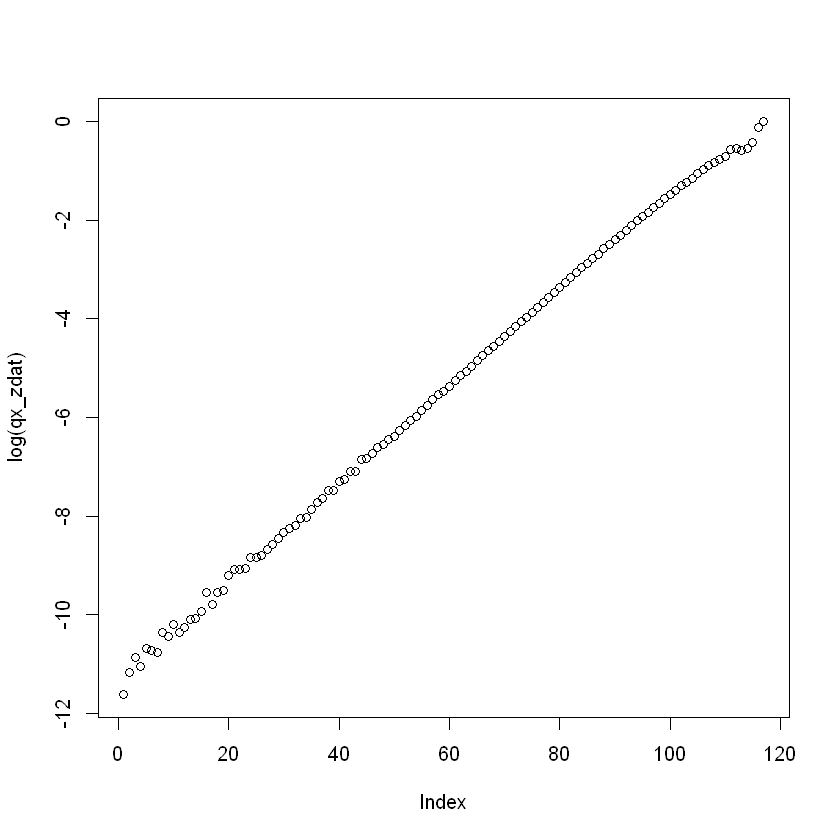

In [128]:
zdat <- GRAN(1000000, 0, 90, 10); summary(zdat);
zdat.clt<-LTLD(zdat); zdat.clt;
qx_zdat <- (-diff(zdat.clt))/zdat.clt[-length(zdat.clt)]
plot(log(qx_zdat))
y <- log(qx_zdat)
omega <- length(y)
x <- 0:(omega-1)
fit <- lm(y~x)
# the estimated coefficient on x ~ g = 1/b in Eq. (8.6)
# the estimated intercept ~ -ln(b) - m/b
summary(fit)


In [146]:
zdat.male <- GRAN(10000,70,80,10)
zdat.female <- GRAN(10000, 65, 90, 10)
female.advantage <- zdat.female - zdat.male
summary(female.advantage)
print(paste("prob that female outlive male: ", sum(female.advantage>=0) / 10000))
print(paste("prob that female life > 15 years + male life: ", sum(female.advantage>=15) / 10000))
print(paste("prob that at least one of the couple survives by age 100: ", sum(zdat.male >= 30 | zdat.female >= 35) / 10000))
# analytical prob that at least one of the couple survives by age 100
1-(1-TPXG(70,30,80,10))*(1-TPXG(65,35,90,10))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -27.27    2.78   11.17   10.61   18.84   44.64 

[1] "prob that female outlive male:  0.8117"
[1] "prob that female life > 15 years + male life:  0.3771"
[1] "prob that at least one of the couple survives by age 100:  0.0729"


[1] 0.07246201

In [161]:
zdat2 <- GRAN(10000,0,85,10)
zdat2.clt <- LTLD(zdat2)
qx <- (-diff(zdat2.clt))/zdat2.clt[-length(zdat2.clt)]

In [162]:
x=55; b=10
gap <- function(m){
    gap <- c()
    for (i in 1:45){
        gap[i] <- abs(TPXG(x,i,m,b) - SPQR(x,x+i,qx))
        }
    sum(gap)
    }

gap(78)
gap(82)
optimize(gap,c(70,100))$minimum
optimize(gap,c(70,100))$objective
gap(85.1)


[1] 5.733789

[1] 2.4519

[1] 84.87546

[1] 0.07270406

[1] 0.195423

In [167]:
b<-10; x<-55
# female, Canadian, 1925 cohort
qx <- qx_f_new
optimize(gap,c(70,100))$minimum
optimize(gap,c(70,100))$objective

b<-11; x<-55
# female, Canadian, 1925 cohort
qx <- qx_f_new
optimize(gap,c(70,100))$minimum
optimize(gap,c(70,100))$objective

b<-10; x<-55
# male, Canadian, 1925 cohort
qx <- qx_m_new
optimize(gap,c(70,100))$minimum
optimize(gap,c(70,100))$objective

b<-13.5; x<-55
# male, Canadian, 1925 cohort
qx <- qx_m_new
optimize(gap,c(70,100))$minimum
optimize(gap,c(70,100))$objective

[1] 88.93967

[1] 0.728548

[1] 89.0909

[1] 0.2142098

[1] 83.02773

[1] 1.374666

[1] 82.04717

[1] 0.1637622

<img src="./figs/Milevsky_p153_fig_8_6.png">

* increasing trend in modal value of life (m)
* the gradual decline in (b)